#***Análisis del sentimiento***


## Librerias

In [52]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

import matplotlib.pyplot as plt

## Carga de datos

In [3]:
data_processed = pd.read_csv('data_processed.csv')

In [4]:
data_processed.head()

,processed_text,Class
0,love game product bought effective im happy wo...,1
1,work described good condition charged device r...,1
2,ill start good first nice little gadget ur n64...,1
3,played game kid many yr ago love playing game ...,1
4,bought gift girlfriend used play game time kid...,1


In [5]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   processed_text  9976 non-null   object
 1   Class           9997 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 156.3+ KB


In [6]:
data_processed.dropna(inplace=True)

In [7]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 9996
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   processed_text  9976 non-null   object
 1   Class           9976 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 233.8+ KB


## Separación train y test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    data_processed['processed_text'],
    data_processed['Class'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [9]:
X_train[:10]

5396    much like one previous review played game long...
2825    ssb game take classic nintendo character battl...
3213    halflife simply unbelievable game keep pc week...
4474                                                scary
2729    okay still dont see everyone talk game hear on...
8530          best nintendo game ever made question asked
177                              simply work disappointed
1646    grew game best game ever graphic crap gameplay...
9289    quake iiin way like doom sixtyfour except with...
5379    definitely top ten favorite game brings back m...
Name: processed_text, dtype: object

In [10]:
y_train[:10]

5396    1
2825    1
3213    1
4474    1
2729    0
8530    1
177     0
1646    1
9289    0
5379    1
Name: Class, dtype: int64

## Modelos

***CountVectorizer***

In [11]:
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [15]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100]

train_acc = list()
test_acc = list()

for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=1000)
    lr.fit(X_train_cv, y_train)

    train_predict = lr.predict(X_train_cv)
    test_predict = lr.predict(X_test_cv)

    print ("Accuracy Train for C={}: {}".format(c, accuracy_score(y_train, train_predict)))
    print ("Accuracy Test for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy Train for C=0.01: 0.8401496925955627
Accuracy Test for C=0.01: 0.8311948676824379
Accuracy Train for C=0.05: 0.8887997861534349
Accuracy Test for C=0.05: 0.8588612670408982
Accuracy Train for C=0.25: 0.9362469927826784
Accuracy Test for C=0.25: 0.8748997594226142
Accuracy Train for C=0.5: 0.9526864474739375
Accuracy Test for C=0.5: 0.8765036086607859
Accuracy Train for C=1: 0.967254744720663
Accuracy Test for C=1: 0.8748997594226142
Accuracy Train for C=10: 0.9910451750868752
Accuracy Test for C=10: 0.863672814755413
Accuracy Train for C=100: 0.9950547981823042
Accuracy Test for C=100: 0.8476343223736968


El valor óptimo del parámetro de regularización C para el modelo de Regresión Logística parece ser 0.5, ya que proporciona un buen rendimiento tanto en el conjunto de entrenamiento como en el de prueba, lo que sugiere una capacidad de generalización efectiva del modelo.

In [16]:
lr = LogisticRegression(C=0.25, solver='lbfgs', max_iter=1000)
lr.fit(X_train_cv, y_train)
y_pred_cv = lr.predict(X_test_cv)

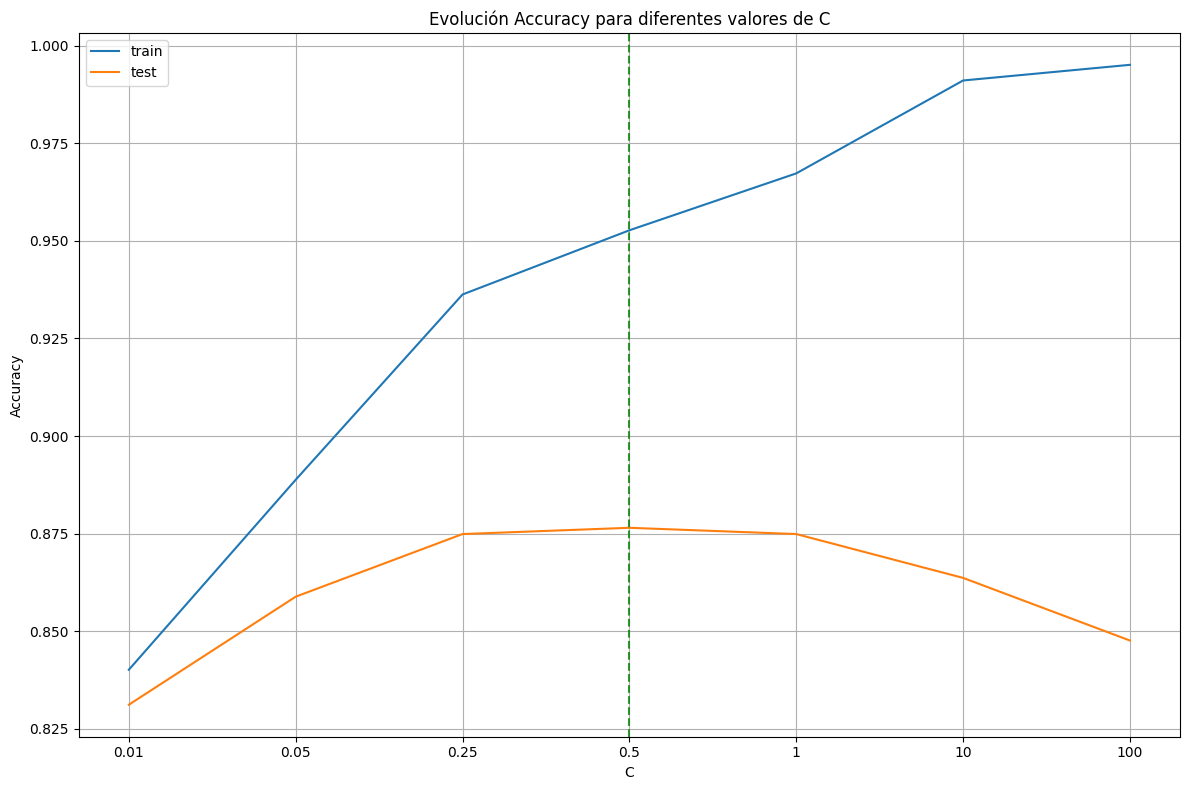

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Evolución Accuracy para diferentes valores de C')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()


In [18]:
print('CountVectorizer simple\n')
print(confusion_matrix(y_test, y_pred_cv))
print(classification_report(y_test, y_pred_cv))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred_cv)))

CountVectorizer simple

[[ 228  230]
 [  82 1954]]
              precision    recall  f1-score   support

           0       0.74      0.50      0.59       458
           1       0.89      0.96      0.93      2036

    accuracy                           0.87      2494
   macro avg       0.82      0.73      0.76      2494
weighted avg       0.87      0.87      0.87      2494

Accuracy score:0.8748997594226142


El modelo tiene un buen desempeño en la predicción de la clase positiva, pero puede ser menos preciso en la predicción de la clase negativa.

Se entrena el modelo con el valor optimo de C.

In [22]:
optimal_lr = LogisticRegression(C=1, solver='lbfgs', max_iter=1000)
optimal_lr.fit(X_train_cv, y_train)

train_predict = optimal_lr.predict(X_train_cv)
test_predict = optimal_lr.predict(X_test_cv)

print ("Accuracy TRAIN for C={}: {}".format(c, accuracy_score(y_train, train_predict)))
print ("Accuracy TEST for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

train_acc.append(accuracy_score(y_train, train_predict))
test_acc.append(accuracy_score(y_test, test_predict))

Accuracy TRAIN for C=100: 0.967254744720663
Accuracy TEST for C=100: 0.8748997594226142


***TfidfVectorizer***

In [27]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    strip_accents='ascii',
    max_df=0.95,
    min_df=3,
    max_features=3000
)
tfidf.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=3000, min_df=3, ngram_range=(1, 3),
                strip_accents='ascii')

In [28]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [31]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=10000)
    lr.fit(X_train_tfidf, y_train)

    train_predict = lr.predict(X_train_tfidf)
    test_predict = lr.predict(X_test_tfidf)

    print ("Accuracy Train for C={}: {}".format(c, accuracy_score(y_train, train_predict)))
    print ("Accuracy Test for C={}: {}".format(c, accuracy_score(y_test, test_predict)))

    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy Train for C=0.01: 0.8106121357925689
Accuracy Test for C=0.01: 0.8163592622293504
Accuracy Train for C=0.05: 0.8126169473402833
Accuracy Test for C=0.05: 0.818364073777065
Accuracy Train for C=0.25: 0.8377439187383052
Accuracy Test for C=0.25: 0.8392141138732959
Accuracy Train for C=0.5: 0.8658112804063085
Accuracy Test for C=0.5: 0.8604651162790697
Accuracy Train for C=1: 0.8924084469393211
Accuracy Test for C=1: 0.8757016840417001
Accuracy Train for C=10: 0.9560278000534617
Accuracy Test for C=10: 0.8765036086607859
Accuracy Train for C=100: 0.9871692060946271
Accuracy Test for C=100: 0.8644747393744988
Accuracy Train for C=1000: 0.9947874899759422
Accuracy Test for C=1000: 0.8496391339214114
Accuracy Train for C=10000: 0.9954557604918471
Accuracy Test for C=10000: 0.8420208500400962


El valor óptimo del parámetro de regularización C para el modelo de Regresión Logística parece ser 10, ya que proporciona un buen rendimiento tanto en el conjunto de entrenamiento como en el de prueba, lo que sugiere una capacidad de generalización efectiva del modelo.

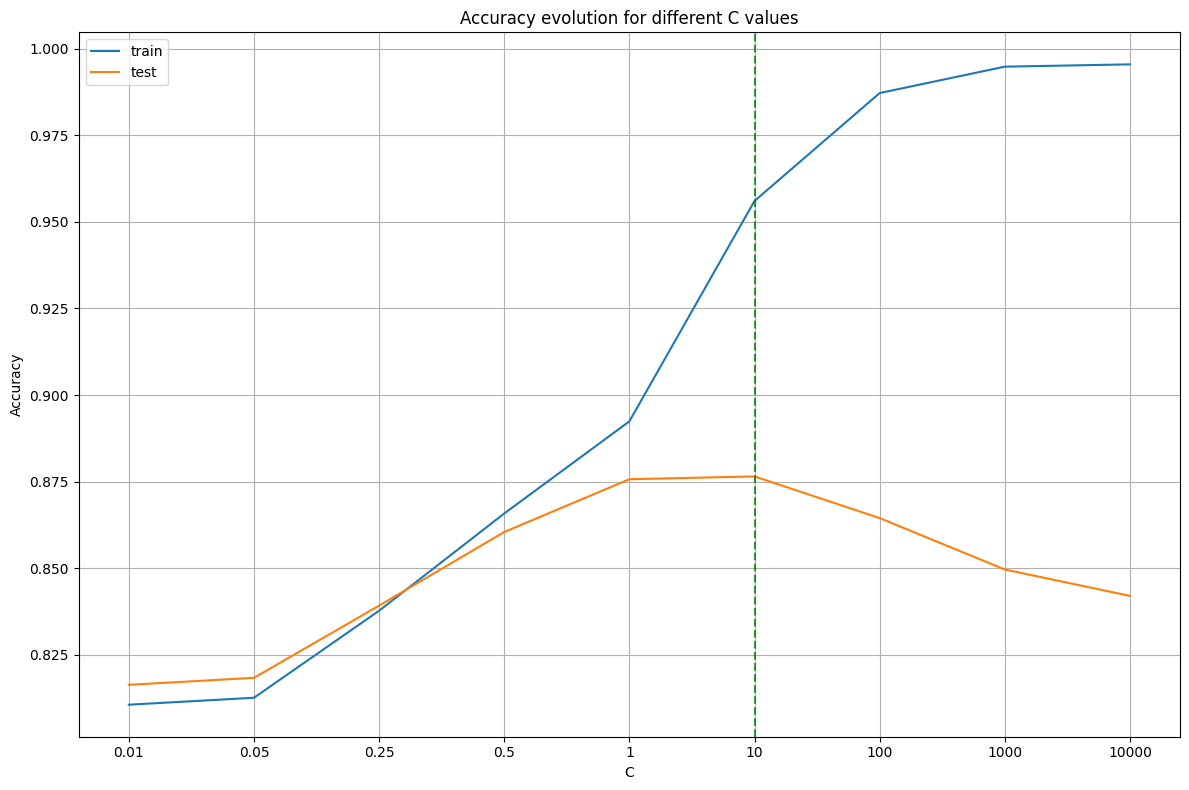

In [32]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [33]:
lr = LogisticRegression(C=10, solver='lbfgs', max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred_tfid = lr.predict(X_test_tfidf)

In [34]:
print('TfidfVectorizer\n')
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

TfidfVectorizer

Confussion matrix:
[[ 280  178]
 [ 216 1820]]

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.61      0.59       458
           1       0.91      0.89      0.90      2036

    accuracy                           0.84      2494
   macro avg       0.74      0.75      0.74      2494
weighted avg       0.85      0.84      0.84      2494

Accuracy score:0.8420208500400962


El modelo mejora en las clasificación positiva pero empeora considerablemente en la negativa.

***GradientBoostingClassifier***

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=42)

    clf.fit(X_train, y_train)

    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))

    return clf


clf2 = classify_gboost(X_train_cv, X_test_cv, y_train, y_test)

[GradientBoostingClassifier] Accuracy: train = 0.8491045175086875, test = 0.8400160384923817


El modelo generaliza bien, ya que la precision en el conjunto de train es relativamente alta  0.8491045175086875. Este modelo parece ser una opción solida con un buen equilibrio entre sesgo y varianza.

***Test de chi cuadrado***

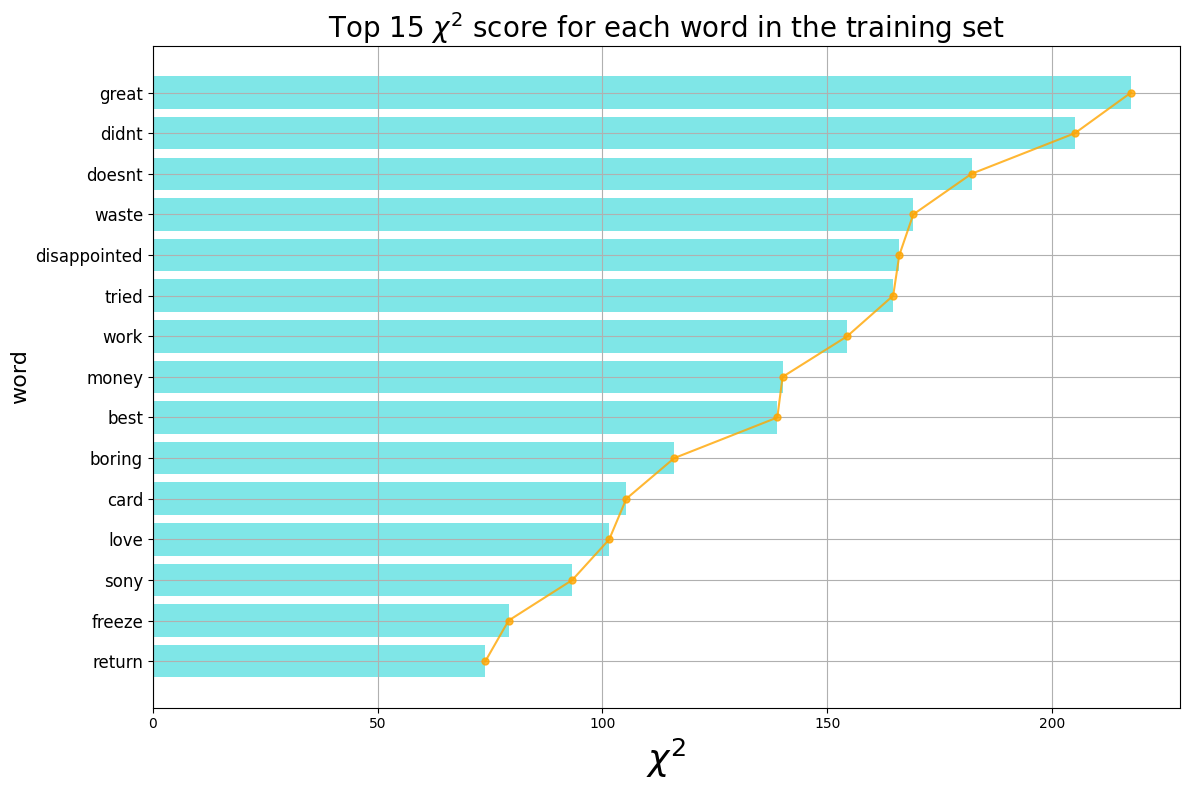

In [36]:
i = 15

chi2score = chi2(X_train_cv, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
bar_color = 'darkturquoise'
line_color = 'orange'
plt.barh(x,topchi2[1], align='center', alpha=0.5, color=bar_color)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8, color=line_color)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

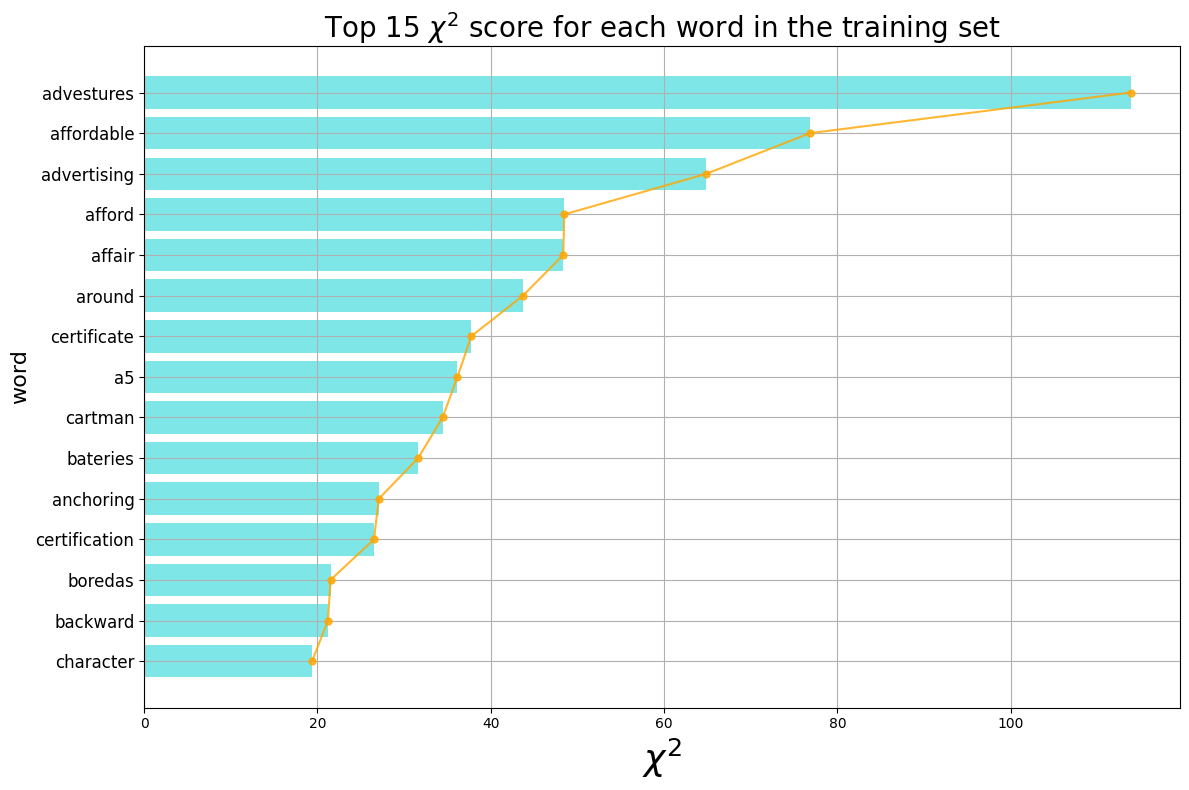

In [37]:
i = 15

chi2score = chi2(X_train_tfidf, y_train)[0]
scores = list(zip(cv.get_feature_names_out(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
bar_color = 'darkturquoise'
line_color = 'orange'
plt.barh(x,topchi2[1], align='center', alpha=0.5, color=bar_color)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8, color=line_color)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

***LSTM***

In [41]:
max = 0
mean = []
for example in X_train:
  length = len(example)
  mean.append(len(example))
  if length > max:
    max = length
print(max)

24825


In [42]:
sum(mean)/len(mean)

258.10906174819564

In [57]:
words = X_train.str.split().explode().reset_index(drop=True)
vocabulary_size =  len(words)
vocabulary_size

297773

In [59]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 32)           9528736   
                                                                 
 lstm_2 (LSTM)               (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 9582037 (36.55 MB)
Trainable params: 9582037 (36.55 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
batch_size = 64
num_epochs = 1

X_valid, y_valid = X_train_dense[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train_dense[batch_size:], y_train[batch_size:]

model.fit(X_train2, y_train2,
          validation_data=(X_valid, y_valid),
          batch_size=batch_size, epochs=num_epochs)

116/116 [==============================] - 25s 182ms/step - loss: 0.4650 - accuracy: 0.8119 - val_loss: 0.4591 - val_accuracy: 0.7969


In [ ]:
scores = model.evaluate(X_test_lstm, y_test, verbose=1)
print("Test accuracy:", scores[1])

78/78 [==============================] - 8s 89ms/step - loss: 0.4773 - accuracy: 0.8164
Test accuracy: 0.816359281539917


 La disminución de la pérdida y el aumento de la precisión en el conjunto de entrenamiento indican que el modelo está aprendiendo de manera efectiva de los datos de entrenamiento y mejorando su capacidad para hacer predicciones correctas. La discrepancia entre la precisión en el conjunto de entrenamiento y el conjunto de validación sugiere que el modelo puede estar sobreajustando los datos de entrenamiento.

****

#***Conclusiones***

Según los resultados obtenidos:

***CountVectorizer:***
Este modelo muestra una precisión general del 87%, con una precisión del 89% para la clase positiva (1) y una precisión del 74% para la clase negativa (0). Si bien tiene una buena precisión global y una alta precisión para la clase positiva, su precisión para la clase negativa es relativamente baja.

***TfidfVectorizer:***
Similar al CountVectorizer, este modelo también muestra una precisión general del 84%, con una precisión del 91% para la clase positiva y una precisión del 56% para la clase negativa. Aunque tiene una alta precisión para la clase positiva, su precisión para la clase negativa es aún más baja que la del CountVectorizer Simple.

***GradientBoostingClassifier:***
LEste modelo alcanza una precisión del 84% tanto en el conjunto de entrenamiento como en el conjunto de prueba. Aunque su rendimiento es sólido, es similar al de los modelos basados en vectorización de texto.

***Deep Learning (LSTM):***
El modelo LSTM alcanza una precisión del 81.64%, lo que indica un rendimiento ligeramente inferior en comparación con los modelos basados en vectorización de texto y GradientBoostingClassifier.





Los modelos basados en CountVectorizer y TfidfVectorizer muestran un rendimiento similar en términos de exactitud y métricas de clasificación.

El modelo basado en GradientBoostingClassifier muestra un rendimiento comparable al de los modelos de vectorización de texto, aunque es ligeramente inferior.

El modelo de Deep Learning (LSTM) muestra un rendimiento competitivo, aunque es ligeramente inferior al de los modelos basados en vectorización de texto y GradientBoostingClassifier en este conjunto de datos específico. Sin embargo, podría tener ventajas en la captura de características secuenciales y contextuales en textos más complejos.



CountVectorizer parece ser el mejor modelo entre los presentados, ya que logra una precisión general más alta y una precisión razonablemente alta tanto para la clase positiva como para la clase negativa.